In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from mlxtend.plotting import plot_learning_curves
from yellowbrick.model_selection import LearningCurve
import matplotlib.gridspec as gridspec
import itertools
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

**Função para gerencia tempo**

In [2]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        tmin, tsec = divmod((datetime.now() - start_time).total_seconds(), 60)
        print('\n Tempo Necessário: %i minutos and %s segundos.' % (tmin, round(tsec, 2)))

**Importação das Bases - Trocaar para base de testes somente após ajustes na validação**
**Verificação dos formatos**

In [3]:
train = pd.read_csv('train.csv')
train = shuffle(train)
X_train = train.iloc[:,1:68] #inserir quantidade de características
Y_train = train.loc[:, train.columns == 'Y'] #inserir label da viriável alvo
test = pd.read_csv('test.csv')
test = shuffle(test)
X_test = test.iloc[:,1:68] #inserir quantidade de características
Y_test = test.loc[:, test.columns == 'Y']#inserir label da viriável alvo

In [4]:
print(X_train.shape)

(109992, 67)


In [5]:
print(X_test.shape)

(65995, 67)


In [6]:
X_train.head()

,v1,v3,v6,v7,v8,v9,v10,v16,v17,v18,...,v687,v689,v690,v691,v694,v56,v64,v72,v74,v78
61174,0,0,0,0,0,1,1,0,0,0,...,-1.00,-1.00,1.0,1.000,1,0.0,0.0,471.81,471.81,0.0
4328,0,0,0,0,0,0,0,0,0,0,...,96.86,-1.00,0.0,0.000,1,0.0,0.0,0.00,0.00,0.0
33522,0,0,0,1,1,1,1,1,1,1,...,-1.00,-1.00,0.0,1.000,1,0.0,0.0,0.00,0.00,0.0
42522,0,0,0,0,0,0,0,0,0,0,...,85.55,1.32,0.0,0.200,1,0.0,0.0,0.00,0.00,0.0
27238,0,0,0,0,0,0,0,0,0,0,...,95.46,100.00,0.0,0.125,4,0.0,0.0,0.00,0.00,0.0


**Modelo árvode de decisão**


 Tempo Necessário: 0 minutos and 3.06 segundos.


<Figure size 432x288 with 0 Axes>

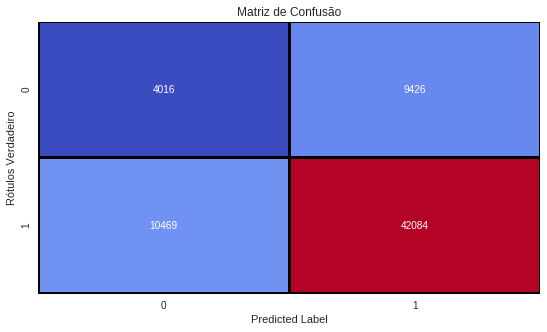

<Figure size 432x288 with 0 Axes>

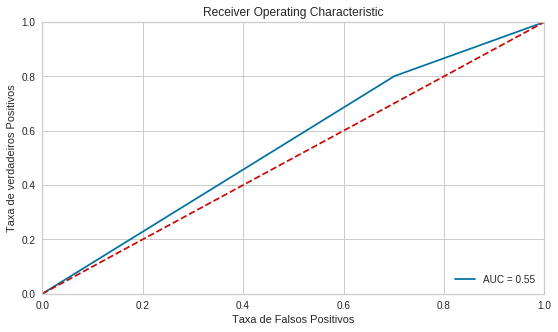

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.28      0.30      0.29     13442
           1       0.82      0.80      0.81     52553

    accuracy                           0.70     65995
   macro avg       0.55      0.55      0.55     65995
weighted avg       0.71      0.70      0.70     65995

Acurácia do Modelo


0.6985377680127283

In [7]:
# Fit a Decision Tree model as comparison
starttime = timer(None)
start_time = timer(None)
clf_DecisionTreeClassifier = DecisionTreeClassifier()
clf_DecisionTreeClassifier.fit(X_train, Y_train.values.ravel())
DecisionTreeClassifier_pred = clf_DecisionTreeClassifier.predict(X_test)
timer(start_time)
accuracy_score(Y_test, DecisionTreeClassifier_pred)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test ,DecisionTreeClassifier_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(1)
matrix_DecisionTreeClassifier = confusion_matrix(Y_test, DecisionTreeClassifier_pred)
plt.figure(figsize=(9,5))
DecisionTreeClassifier = sns.heatmap(matrix_DecisionTreeClassifier, annot=True, cbar=False, fmt="d", cmap ='coolwarm', linecolor ='black', linewidths = 2)
bottom, top = DecisionTreeClassifier.get_ylim()
DecisionTreeClassifier.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Rótulos Verdadeiro')
plt.xlabel('Predicted Label')
plt.title('Matriz de Confusão')
plt.show()



plt.figure(2)
plt.figure(figsize=(9,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.0,1.0])
plt.ylim([-0.0,1.0])
plt.ylabel('Taxa de verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')
plt.show()



print("Relatório de Classificação")
print(classification_report(Y_test, DecisionTreeClassifier_pred))

print("Acurácia do Modelo")
accuracy_score(Y_test, DecisionTreeClassifier_pred)

**Modelo Random Forest**


 Tempo Necessário: 1 minutos and 30.18 segundos.


<Figure size 432x288 with 0 Axes>

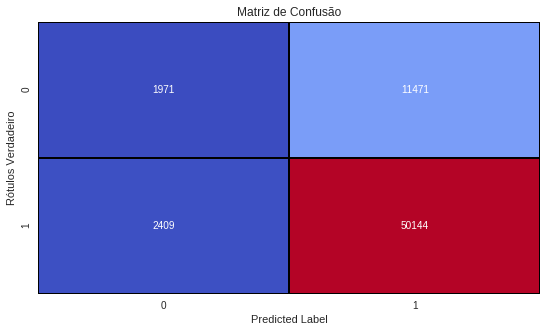

<Figure size 432x288 with 0 Axes>

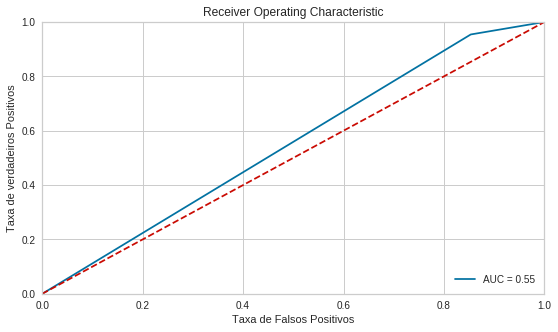

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.45      0.15      0.22     13442
           1       0.81      0.95      0.88     52553

    accuracy                           0.79     65995
   macro avg       0.63      0.55      0.55     65995
weighted avg       0.74      0.79      0.74     65995

Acurácia do Modelo
Acurácia do Modelo Cross Validation
0.7871299687682188


In [8]:
starttime = timer(None)
start_time = timer(None)
clf = RandomForestClassifier(n_estimators=100, max_features="auto",random_state=0)
clf.fit(X_train, Y_train.values.ravel())
scores = cross_val_score(clf, X_train, Y_train.values.ravel(), cv=3)
RandomForestClassifier_pred = clf.predict(X_test)
timer(start_time)
accuracy_score(Y_test, RandomForestClassifier_pred)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, RandomForestClassifier_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


plt.figure(1)
matrix_RandomForestClassifier = confusion_matrix(Y_test, RandomForestClassifier_pred)
plt.figure(figsize=(9,5))
map_RandomForestClassifier = sns.heatmap(matrix_RandomForestClassifier, annot=True, cbar=False, fmt="d", cmap ='coolwarm', linecolor ='black', linewidths = 1)
bottom, top = map_RandomForestClassifier.get_ylim()
map_RandomForestClassifier.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Rótulos Verdadeiro')
plt.xlabel('Predicted Label')
plt.title('Matriz de Confusão')
plt.show()

plt.figure(2)
plt.figure(figsize=(9,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.0,1.0])
plt.ylim([-0.0,1.0])
plt.ylabel('Taxa de verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')
plt.show()



print("Relatório de Classificação")
print(classification_report(Y_test, RandomForestClassifier_pred))

print("Acurácia do Modelo")
accuracy_score(Y_test, RandomForestClassifier_pred)

print("Acurácia do Modelo Cross Validation")
print(scores.mean())

**Modelo AdaBoost**


 Tempo Necessário: 0 minutos and 51.64 segundos.


<Figure size 432x288 with 0 Axes>

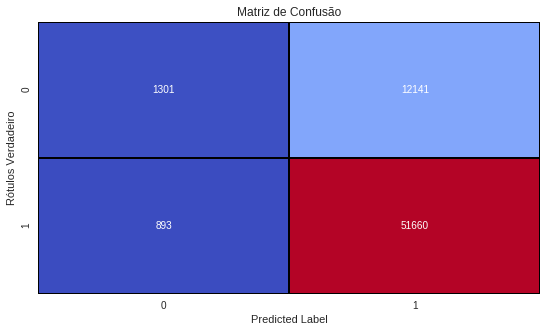

<Figure size 432x288 with 0 Axes>

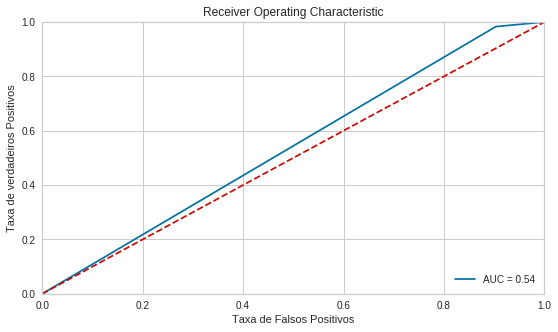

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.59      0.10      0.17     13442
           1       0.81      0.98      0.89     52553

    accuracy                           0.80     65995
   macro avg       0.70      0.54      0.53     65995
weighted avg       0.77      0.80      0.74     65995

Acurácia do Modelo
Acurácia do Modelo Cross Validation
0.7987944388331912


In [9]:
starttime = timer(None)
start_time = timer(None)
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train, Y_train.values.ravel())
AdaBoostClassifier_pred = clf.predict(X_test)
scores = cross_val_score(clf, X_train, Y_train.values.ravel(), cv=3)
timer(start_time)
accuracy_score(Y_test, AdaBoostClassifier_pred)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, AdaBoostClassifier_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


plt.figure(1)
matrix_AdaBoostClassifier = confusion_matrix(Y_test, AdaBoostClassifier_pred)
plt.figure(figsize=(9,5))
map_matrix_AdaBoostClassifier = sns.heatmap(matrix_AdaBoostClassifier, annot=True, cbar=False, fmt="d", cmap ='coolwarm', linecolor ='black', linewidths = 1)
bottom, top = map_matrix_AdaBoostClassifier.get_ylim()
map_matrix_AdaBoostClassifier.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Rótulos Verdadeiro')
plt.xlabel('Predicted Label')
plt.title('Matriz de Confusão')
plt.show()

plt.figure(2)
plt.figure(figsize=(9,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.0,1.0])
plt.ylim([-0.0,1.0])
plt.ylabel('Taxa de verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')
plt.show()


print("Relatório de Classificação")
print(classification_report(Y_test, AdaBoostClassifier_pred))

print("Acurácia do Modelo")
accuracy_score(Y_test, AdaBoostClassifier_pred)

print("Acurácia do Modelo Cross Validation")
print(scores.mean())

**Modelo Gradient Boosting**

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.60      0.11      0.18     13442
           1       0.81      0.98      0.89     52553

    accuracy                           0.80     65995
   macro avg       0.71      0.54      0.54     65995
weighted avg       0.77      0.80      0.74     65995

Acurácia do Modelo
Acurácia do Modelo Cross Validation
0.7995763225581047


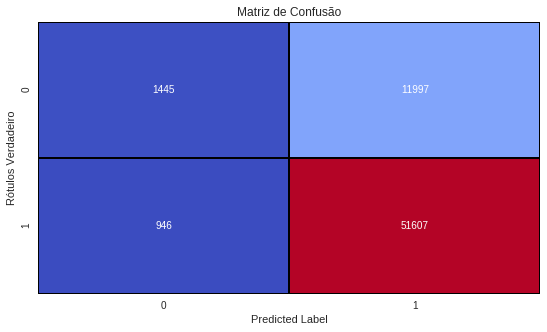

In [10]:
gb_clf2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.5, max_features=2, max_depth=2, random_state=1)
gb_clf2.fit(X_train, Y_train.values.ravel())
GradientBoostingClassifier_predictions = gb_clf2.predict(X_test)

matrix_GradientBoostingClassifier2 = confusion_matrix(Y_test, GradientBoostingClassifier_predictions)
scores = cross_val_score(gb_clf2, X_train, Y_train.values.ravel(), cv=3)
plt.figure(figsize=(9,5))
map_matrix_GradientBoostingClassifier2 = sns.heatmap(matrix_GradientBoostingClassifier2, annot=True, cbar=False, fmt="d", cmap ='coolwarm', linecolor ='black', linewidths = 1)
bottom, top = map_matrix_GradientBoostingClassifier2.get_ylim()
map_matrix_GradientBoostingClassifier2.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Rótulos Verdadeiro')
plt.xlabel('Predicted Label')
plt.title('Matriz de Confusão')



print("Relatório de Classificação")
print(classification_report(Y_test, GradientBoostingClassifier_predictions))

print("Acurácia do Modelo")
accuracy_score(Y_test, GradientBoostingClassifier_predictions)

print("Acurácia do Modelo Cross Validation")
print(scores.mean())

**Modelo XGboost**


 Tempo Necessário: 0 minutos and 14.02 segundos.


<Figure size 432x288 with 0 Axes>

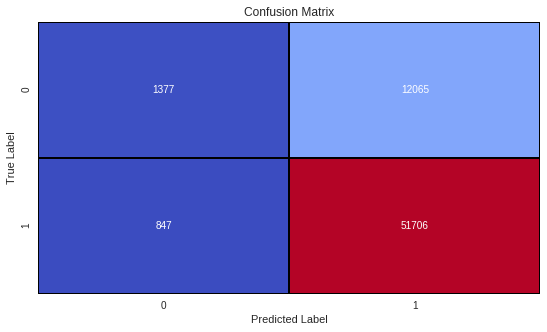

<Figure size 432x288 with 0 Axes>

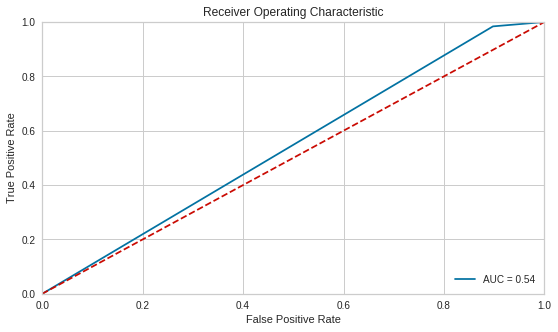

<Figure size 432x288 with 0 Axes>

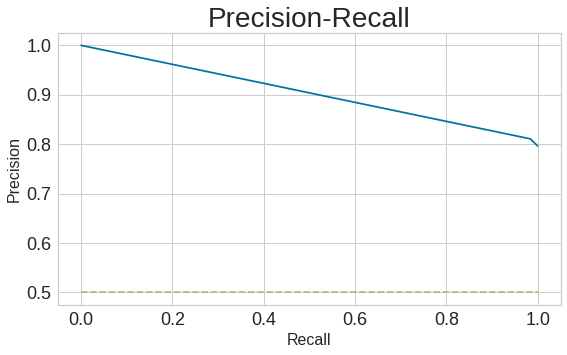

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.10      0.18     13442
           1       0.81      0.98      0.89     52553

    accuracy                           0.80     65995
   macro avg       0.71      0.54      0.53     65995
weighted avg       0.77      0.80      0.74     65995

Acurácia do Modelo
Acurácia do Modelo Cross Validation
0.8008764188468409


In [11]:
starttime = timer(None)
start_time = timer(None)
xgb_clf = XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=1, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='reg:squarederror', random_state=1,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
xgb_clf.fit(X_train, Y_train.values.ravel())
predictions_xgb = xgb_clf.predict(X_test)
scores = cross_val_score(xgb_clf, X_train, Y_train.values.ravel(), cv=3)
timer(start_time)

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, predictions_xgb)
roc_auc = auc(false_positive_rate, true_positive_rate)
matrix_xgb_clf = confusion_matrix(Y_test, predictions_xgb)



plt.figure(1)
plt.figure(figsize=(9,5))
xgb_clf_heatmap = sns.heatmap(matrix_xgb_clf,annot=True, cbar=False, fmt="d", cmap ='coolwarm', linecolor ='black', linewidths = 1)
bottom, top = xgb_clf_heatmap.get_ylim()
xgb_clf_heatmap.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

plt.figure(2)
plt.figure(figsize=(9,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.0,1.0])
plt.ylim([-0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.figure(3)
precision, recall, thresholds = precision_recall_curve(Y_test, predictions_xgb)
plt.figure(figsize = (9,5))
plt.plot(recall, precision)
plt.plot([0, 1], [0.5, 0.5], linestyle = '--')
plt.xlabel('Recall', fontsize = 16)
plt.ylabel('Precision', fontsize = 16)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.title('Precision-Recall', fontsize = 28)
plt.show();


print("Classification Report")
print(classification_report(Y_test, predictions_xgb))

print("Acurácia do Modelo")
accuracy_score(Y_test, predictions_xgb)

print("Acurácia do Modelo Cross Validation")
print(scores.mean())

**Curvas de aprendizagem**

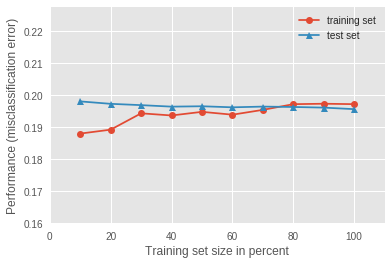

In [12]:
plt.figure()
plot_learning_curves(X_train, Y_train.values.ravel(), X_test, Y_test.values.ravel(), xgb_clf, print_model=False, style='ggplot')
plt.show()